In [1]:
#!/usr/bin/env python
# ============================================================
#  SITS-BERT  ·  California-Labeled  ·  6-band data prep
# ------------------------------------------------------------
#  Reads  : /kaggle/input/california-labeled/{Train,Validate,Test}.csv
#  Writes : /kaggle/working/data/6_features_{Train,Validate,Test}.csv
# ------------------------------------------------------------
#  Each output row = 24 × 7 floats  (B1-6 + DOY)  +  label
# ============================================================

import csv, subprocess, sys, shutil, random
from pathlib import Path
import numpy as np

In [2]:
# ───────────────────────────────────
# 0 · CONFIG
# ───────────────────────────────────
SEED       = 42
SRC_DIR    = Path("/kaggle/input/california-labeled")
DST_DIR    = Path("/kaggle/working/data")
SITS_REPO  = Path("/kaggle/working/SITS-BERT")
T_KEEP     = 24                       # timesteps to keep / pad
FEATS_KEEP = [0, 1, 2, 3, 4, 5, 10]   # 6 bands + DOY   (drop 10 to remove DOY)
F_SOURCE   = 11                       # 10 spectral bands + DOY in original rows


In [3]:
# ───────────────────────────────────
# 1 · ENVIRONMENT
# ───────────────────────────────────
def _sh(cmd: str) -> None:
    print(f"[shell] {cmd}")
    subprocess.check_call(cmd, shell=True)

def ensure_env() -> None:
    """Install lightweight deps & clone SITS-BERT once."""
    if not shutil.which("pandas"):
        _sh("pip install -q pandas numpy")
    if not SITS_REPO.exists():
        _sh(f"git clone -q https://github.com/linlei1214/SITS-BERT.git {SITS_REPO}")
    sys.path.append(str(SITS_REPO))

In [4]:
# ───────────────────────────────────
# 2 · ROW SLICE HELPER
# ───────────────────────────────────
def slice_row(row: list[str]) -> list[str] | None:
    """
    Return a flattened row: 24×selected-features + label.
    Skip malformed rows (those whose length-1 isn't divisible by 11).
    
    Input format: [spectral_data..., class_label]  # Class is LAST column
    Output format: [band1_t1, band1_t2, ..., band1_t24, band2_t1, ..., DOY_t24, class]
    """
    label = row[-1]  # Class label is in the LAST column
    floats = row[:-1]  # Everything except the last column (all spectral data)
    
    if (len(floats) % F_SOURCE) != 0:
        return None                               # corrupt → skip
    
    T_full = len(floats) // F_SOURCE              # actual steps (41–45)
    
    # --- pad if shorter than 24 (very rare) -----
    if T_full < T_KEEP:
        # Need to pad each band separately
        padded_floats = []
        for band_idx in range(F_SOURCE):
            band_start = band_idx * T_full
            band_data = floats[band_start:band_start + T_full]
            # Pad this band to T_KEEP length
            band_data.extend(['0'] * (T_KEEP - T_full))
            padded_floats.extend(band_data)
        floats = padded_floats
        T_full = T_KEEP
    
    # -------- build the output (features … label) --------
    out = []
    for f in FEATS_KEEP:                          # each wanted feature (band)
        band_start = f * T_full                   # start index of that band
        out.extend(floats[band_start : band_start + T_KEEP])  # first 24 values of this band
    
    out.append(label)
    return out


In [5]:
# ───────────────────────────────────
# 3 · PROCESS ONE SPLIT
# ───────────────────────────────────
def process_split(split: str) -> None:
    src = SRC_DIR / f"{split}.csv"
    dst = DST_DIR / f"6_features_{split}.csv"
    kept = skipped = 0
    
    with src.open() as fin, dst.open("w", newline="") as fout:
        reader, writer = csv.reader(fin), csv.writer(fout)
        for row in reader:
            new_row = slice_row(row)
            if new_row is None:
                skipped += 1
            else:
                writer.writerow(new_row)
                kept += 1
    
    print(f"{split:<8}: wrote {kept:>6} rows   |   skipped {skipped}")

In [6]:
# ───────────────────────────────────
# 4 · MAIN
# ───────────────────────────────────
def main() -> None:
    random.seed(SEED); np.random.seed(SEED)
    ensure_env()
    DST_DIR.mkdir(parents=True, exist_ok=True)
    
    for split in ["Train", "Validate", "Test"]:
        process_split(split)
    
    print("\n🟢 All done — cleaned files live in /kaggle/working/data/")
    print(f"    Each row = {T_KEEP} × {len(FEATS_KEEP)} floats + label")

In [7]:
# ───────────────────────────────────
if __name__ == "__main__":
    main()

[shell] pip install -q pandas numpy
[shell] git clone -q https://github.com/linlei1214/SITS-BERT.git /kaggle/working/SITS-BERT
Train   : wrote   1300 rows   |   skipped 0
Validate: wrote   1300 rows   |   skipped 0
Test    : wrote 318588 rows   |   skipped 0

🟢 All done — cleaned files live in /kaggle/working/data/
    Each row = 24 × 7 floats + label


In [8]:
!mkdir checkpoints_finetune

In [9]:
def debug_output_shape():
    import pandas as pd
    df = pd.read_csv('/kaggle/working/data/6_features_Train.csv', header=None)
    sample_row = df.iloc[0].values
    features = sample_row[:-1]  # everything except label
    label = sample_row[-1]
    
    print(f"Output features shape: {len(features)}")
    print(f"Expected: 24 timesteps × 7 features = {24 * 7}")
    print(f"Label: {label}")
    print(f"Features sample: {features[:14]}")  # first 2 timesteps worth

In [10]:
debug_output_shape()

Output features shape: 168
Expected: 24 timesteps × 7 features = 168
Label: 7
Features sample: [808 647 487 459 446 463 464 518 433 532 537 400 549 518]


In [11]:
!sed -i "s#self.pooling = nn.MaxPool1d(64)#self.pooling = nn.MaxPool1d(24)#" /kaggle/working/SITS-BERT/code/model/classification_model.py

In [12]:
!python /kaggle/working/SITS-BERT/code/finetuning.py \
  --file_path /kaggle/working/data/6_features_ \
  --pretrain_path '/kaggle/input/doyt2c/transformers/default/1/' \
  --finetune_path /kaggle/working/checkpoints_finetune/ \
  --num_features 6 \
  --max_length 24 \
  --num_classes 13 \
  --epochs 100 \
  --batch_size 128 \
  --hidden_size 256 \
  --layers 3 \
  --attn_heads 8 \
  --learning_rate 2e-4 \
  --dropout 0.1

2025-06-15 17:13:22.079027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750007602.265699     101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750007602.319851     101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading Data sets...
training samples: 1300, validation samples: 1300, testing samples: 318588
Creating Dataloader...
Initialing SITS-BERT...
Loading pre-trained model parameters...
Creating Downstream Task Trainer...
Fine-tuning SITS-BERT...
EP0, train_OA=11.92, train_Kappa=0.046, validate_OA=17.00, validate_Kappa=0.101
EP:0 Model Saved on: /kaggle/working/checkpoints_finetune/checkpoint.tar
EP1, train_OA=16.62, train_Kappa=0.097, v

In [13]:
ls /kaggle/working/SITS-BERT/code/

dataset/       model/          run_finetuning.sh             run_pretraining.sh
finetuning.py  pretraining.py  run_finetuning_unpretrain.sh  trainer/


✅ Loaded 318,588 samples (6-band + DOY × 24, 13 classes)
✅ Checkpoint loaded: /kaggle/working/checkpoints_finetune/checkpoint.tar

              precision    recall  f1-score   support

           0     0.9201    0.9298    0.9249      3804
           1     0.9259    0.9356    0.9308     24301
           2     0.2934    0.9619    0.4497      2180
           3     0.8865    0.9510    0.9176     14623
           4     0.8413    0.9067    0.8728     13192
           5     0.9498    0.7668    0.8486     66592
           6     0.7427    0.8623    0.7980     11741
           7     0.9256    0.8553    0.8891     53761
           8     0.5806    0.7899    0.6693     14352
           9     0.2614    0.6303    0.3695      1666
          10     0.8675    0.9879    0.9238      2968
          11     0.9772    0.9339    0.9551     74918
          12     0.7583    0.8256    0.7905     34490

    accuracy                         0.8637    318588
   macro avg     0.7639    0.8721    0.7954    318588
wei

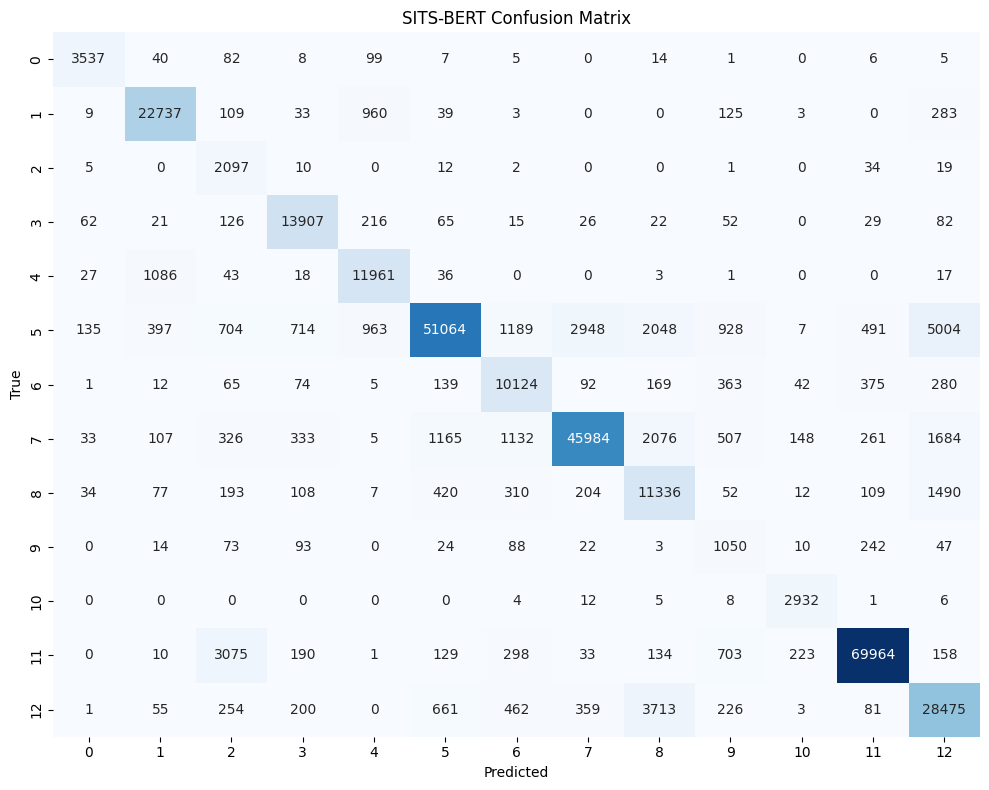

In [28]:
%matplotlib inline

import sys, inspect, csv, numpy as np, torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ───────────────────────────── Configuration ──────────────────────────────
ROOT       = Path("/kaggle/working")                       # adjust as needed
CSV_TEST   = ROOT / "data" / "6_features_Test.csv"
CKPT_FILE  = ROOT / "checkpoints_finetune" / "checkpoint.tar"
SITS_REPO  = ROOT / "SITS-BERT" / "code"
BATCH_SIZE = 128
SEQ_LEN    = 24
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────── Add repo to path & import ────────────────────────────────────
sys.path.append(str(SITS_REPO))
from model.classification_model import SBERTClassification
from model.bert                 import SBERT

# ─────────── Build SBERT helper ──────────────────────────────────────────
_sig = inspect.signature(SBERT.__init__)
def make_sbert(num_features: int) -> torch.nn.Module:
    # SBERT.__init__(self, num_features, hidden, n_layers, attn_heads, dropout=0.1)
    base = {
        "num_features": num_features,
        "hidden":       256,
        "n_layers":     3,
        "attn_heads":   8,
        "dropout":      0.1,
    }
    kwargs = {k: v for k, v in base.items() if k in _sig.parameters}
    missing = [
        p.name for p in _sig.parameters.values()
        if p.default is inspect._empty and p.name not in kwargs and p.name != "self"
    ]
    if missing:
        raise RuntimeError(f"❌ Missing SBERT init args: {missing}")
    return SBERT(**kwargs)

# ─────────── Dataset ──────────────────────────────────────────────────────
class SITSCSVDataset(Dataset):
    """
    Parses CSV rows of (SEQ_LEN * n_feat floats) + label,
    where n_feat = 7 (6 spectral bands + DOY).
    The CSV is organized band-by-band, so we reshape then transpose.
    """
    def __init__(self, path: Path, seq_len: int = 24):
        rows   = list(csv.reader(path.open()))
        n_feat = (len(rows[0]) - 1) // seq_len
        spec   = n_feat - 1  # last channel is DOY

        X, D, Y = [], [], []
        for r in rows:
            if not r: 
                continue
            arr = np.asarray(r[:-1], dtype=np.float32)
            if arr.size != seq_len * n_feat:
                continue
            # reshape band-major → time-major
            seq = arr.reshape(n_feat, seq_len).T  # [SEQ_LEN, n_feat]
            X.append(seq[:, :spec])               # [SEQ_LEN, spec]
            D.append(seq[:,  spec].astype(np.int64))  # [SEQ_LEN]
            Y.append(int(r[-1]))

        self.x   = torch.tensor(np.stack(X) / 10000.0, dtype=torch.float32)          # [N, SEQ_LEN, spec]
        self.doy = torch.tensor(np.stack(D))          # [N, SEQ_LEN]
        self.y   = torch.tensor(Y, dtype=torch.long)  # [N]
        print(f"✅ Loaded {len(self):,} samples "
              f"({spec}-band + DOY × {seq_len}, {int(self.y.max()+1)} classes)")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.doy[idx], self.y[idx]

# ─────────── Evaluation ───────────────────────────────────────────────────
# 1) Load data
ds     = SITSCSVDataset(CSV_TEST, SEQ_LEN)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)

# 2) Build model & send to device
sbert = make_sbert(ds.x.size(-1))
model = SBERTClassification(sbert, int(ds.y.max()+1)).to(DEVICE)

# 3) Strictly load checkpoint
ckpt = torch.load(CKPT_FILE, map_location=DEVICE)
res  = model.load_state_dict(ckpt["model_state_dict"], strict=True)
print("✅ Checkpoint loaded:", CKPT_FILE)
if res.missing_keys:
    print("⚠️ Missing keys:", res.missing_keys)
if res.unexpected_keys:
    print("⚠️ Unexpected keys:", res.unexpected_keys)

model.eval()

# 4) Get positional-embedding size & clamp DOY
pe      = model.sbert.embedding.position.pe
pe_size = pe.size(0)

# 5) Inference
y_true, y_pred = [], []
with torch.no_grad():
    for xb, doy, yb in loader:
        xb  = xb.to(DEVICE)
        doy = torch.clamp(doy.to(DEVICE).long() - 1, 0, pe_size - 1)
        mask = torch.ones(xb.size(0), SEQ_LEN, dtype=torch.bool, device=DEVICE)

        logits = model(xb, doy, mask)
        preds  = logits.argmax(dim=1).cpu().tolist()
        y_pred.extend(preds); y_true.extend(yb.tolist())

# 6) Classification report (no warnings)
print("\n" + classification_report(
    y_true, y_pred, digits=4, zero_division=0
))

# 7) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
try:
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
except ImportError:
    plt.imshow(cm, interpolation="nearest", aspect="auto")
plt.title("SITS-BERT Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()